# Black Jack stylised environment

## Deck Setup 
1. Card Suits : Spades, Hearts, Diamonds and Clubs
2. Face Cards : Kings, Queens and Jacks
3. Ace = Aces
4. Number cards : 2 to 10

# Card value setup

1. Face cards : 10
2. Ace : 11 if bust 1
3. Number : Numerical value equal to their number

# Reward Function

![Cost function](images/cost_function.png)

## Doubts
1. When calculating the score for the hand, when there is unusable ace, should be count that as 1 or 11?
2. How do we score and end the game when there is only one last card left in the deck and still the agent wants to stick?
4. How do I make reward after each state and action, question seems to give reward only after a hand is finished?
    1. *The reward in this game is sparse, as we only know how to label the last state in a hand with a reward. Think back to how the rewards are assigned in the chess example in the lectures - we give a non-zero reward at the end for a win/lose outcome and 0 otherwise for all other transitions.*
5. MonteCarloES already achieves good result (That's what we think), verify it, if it is really the optimal result. And what would be be improving if we incorporated changing environment and using function approximation methods or policy gradient methods.


# TODO
1. Run variations iteration and find the nth iteration when the agent's q values shows minimal change to tell when the agent reached a optimal policy
2. Find other plots like training error, rewards throughout the iterations
3. Add Usable ace in the state
4. <font color='red'> Consideration changing environment in the agent algorithm, if not suitable for MonteCarloES, try to implement another algorithm which might helps achieve that </font>

# <font color='orange'>Inferences</font>

1. Tendency to stick increases at an early point of time (in terms of sum of the hand as state) with decrease in Gamma value

In [5]:
import numpy as np
import random

from utils.blackjack_env_builder import BlackJackStylised
from utils.scorer import Scorer, quadratic_scorer
from tqdm import tqdm
from matplotlib import pyplot as plt
from utils.general import plot_monte_carlo_q_values

In [11]:
class MonteCarloES:
    '''
    Monte Carlo Exploring starts algorithm
    '''
    
    # TODO Print the number of states and actions along with the defined init_configurations
    def __init__(self, init_config:dict, actions, verbose=False, epsilon_decay=False,
                 epsilon_decay_param={"min_epsilon":0.05, "max_epsilon":0, "decay_factor":0.0005}): 
        
        self.actions = actions
        self.init_config = init_config
        self.epsilon_decay_param = epsilon_decay_param
        if epsilon_decay:
            self.epsilon_decay_param['max_epsilon'] = self.init_config['epsilon']
        self.initialize_Q()
        
    def epsilon_greedy_policy(self, state):
        
        hand_sum, usable_ace = state
        # hand_sum, usable_ace, deck_feature = state
        if random.random() < self.init_config['epsilon']:
            return random.choice(self.actions)
        else:
            ## return np.argmax(self.Q[int(current_sum), usable_ace, deck_feature])
            return np.argmax(self.Q[int(hand_sum), usable_ace, :, 0])
        

        
    def initialize_Q(self):
        '''
        Zero initialized Q values
        '''
        self.Q = np.zeros((len(self.init_config['states']['state_dim_1']),
                           len(self.init_config['states']['state_dim_2']), len(self.actions), 2)) 
        
    
    def epsilon_decay(self, episode_num):
        
        if not self.epsilon_decay:
            raise Exception('Epsion Decay is turned off!, Reinitialze the class with epsion decay flag to True')
        min_epsilon = self.epsilon_decay_param['min_epsilon']
        max_epsilon = self.epsilon_decay_param['max_epsilon']
        decay_factor = self.epsilon_decay_param['decay_factor']
        
        self.init_config['epsilon'] = min_epsilon + (max_epsilon - min_epsilon)*np.exp(-decay_factor*episode_num) 
            
    def _moving_average_returns(self, hand_sum, usable_ace, action, G):
        
        curr_val = self.Q[hand_sum][usable_ace][action][0]
        count = self.Q[hand_sum][usable_ace][action][1]
        
        mov_avg = curr_val + ((G - curr_val)/count)
        # mov_avg = (curr_val * count + G)/ count + 1 
        
        return mov_avg
            
        
    def policy_evaluation(self, episode):
        
        # Starting from reverse order for policy evaluation
        # for episode in episodes:
        state_repeat_check = []
        G = 0
        for hand_sum, usable_ace, action, reward in reversed(episode):

            G = self.init_config['gamma']*G + reward

            if (hand_sum, usable_ace, action) not in state_repeat_check:
                state_repeat_check.append((int(hand_sum), usable_ace, action))
                # print(self.Q.shape)
                # print([int(hand_sum),usable_ace, action,1])
                # print()
                self.Q[int(hand_sum)][usable_ace][action][1] += 1
                self.Q[int(hand_sum)][usable_ace][action][0] = self._moving_average_returns(int(hand_sum), usable_ace, action, G)
            

## For infinite Decks

In [16]:
env = BlackJackStylised(num_decks=3)

In [17]:
init_config= {'init_state_action_val': 0,
              'epsilon' : 0.25,
              'gamma' : 0.75,
              'states' : {'state_dim_1':list(range(2, 22)),
                          'state_dim_2': [0,1]}}
agent_v1 = MonteCarloES(init_config=init_config, actions=[0, 1], epsilon_decay=True)

In [18]:
# cards, curr_sum, usable_ace, hand_complete = env.reset_init(hard=True)
total_episodes = 100000
episode_break_flag = True

# Offset to account for Q-value array indexing
sum_offset = 2

# DEBUG variables
break_bool = False

# episodes = []
for i in tqdm(list(range(total_episodes))):
    episode = []
    episode_break_flag = True
    cards, curr_sum, usable_ace, hand_complete = env.reset_init(hard=True)
    curr_sum -= sum_offset 
    
    if not hand_complete:
        while episode_break_flag:
            action = agent_v1.epsilon_greedy_policy((curr_sum, int(usable_ace)))
            # print(action)
            cards, new_sum, usable_ace, hand_complete = env.step(action)


            if new_sum > 21 or hand_complete == True:
                
                reward = quadratic_scorer(curr_sum)
                episode.append([curr_sum, int(usable_ace), action, reward])
                curr_sum = new_sum
                
                if env.deck_complete:
                    episode_break_flag = False
                    break
                    
                cards, curr_sum, usable_ace, hand_complete = env.reset_init()
                curr_sum -= sum_offset
                
                if env.deck_complete:
                    episode_break_flag = False
                    break

                continue

            reward = 0
            episode.append([curr_sum, int(usable_ace), action, reward])
            curr_sum = new_sum - sum_offset



    agent_v1.policy_evaluation(episode)
    agent_v1.epsilon_decay(i)
    # episodes.append(episode)
       

100%|█████████████████████████████████████████████████████████████████████████| 100000/100000 [05:04<00:00, 328.78it/s]


## With Epsilon Decay

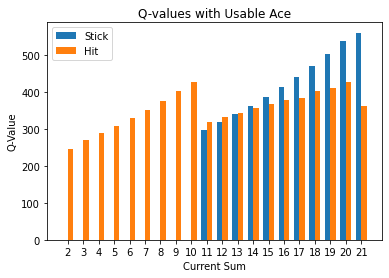

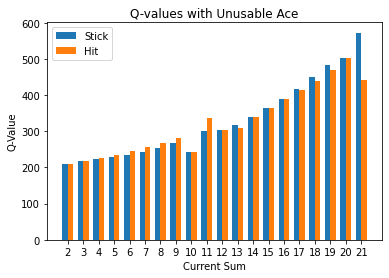

In [19]:
plot_monte_carlo_q_values(agent_v1, usable_ace=True, deck_feature_representative=1)  # For usable ace
plot_monte_carlo_q_values(agent_v1, usable_ace=False, deck_feature_representative=1) # For unusable ace

## With constant Epsilon

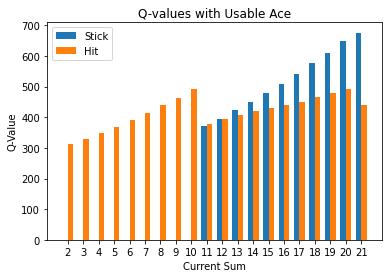

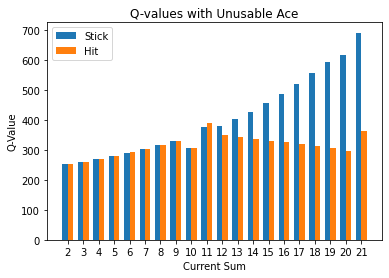

In [125]:
plot_monte_carlo_q_values(agent_v1, usable_ace=True, deck_feature_representative=1)  # For usable ace
plot_monte_carlo_q_values(agent_v1, usable_ace=False, deck_feature_representative=1) # For unusable ace

# Additions to Monte Carlo
1. Adding usable ace to the state
2. epsilon decay
3. Change in environment accountability
4. return plots, training error, Q-values

In [24]:
def evaluate_agent(n_eval_episodes, Q):
  # Assuming you have an instance of your environment
  env = BlackJackStylised(num_decks=3)
  episode_rewards = []
#   print(Q)
  for episode in tqdm(range(n_eval_episodes)):
      total_rewards_ep = 0
      cards, current_sum, usable_ace, hand_complete = env.reset_init(hard=True)
      # print(env.card_counter)
      # deck_feature = get_deck_feature(env.card_counter)
      # print(deck_feature)
      state = (int(current_sum-1), int(usable_ace))
      done = hand_complete

      
      while not env.deck_complete: ## 1 episode
          while not done: ## 1 Hand
              if env.deck_complete:
                  break
              # print(Q)
              # print(int(current_sum), usable_ace)
              # print(Q[int(current_sum), usable_ace])
              action = np.argmax(Q[int(current_sum-1), int(usable_ace)])
              # print(action)
              next_cards, next_sum, next_usable_ace, hand_complete = env.step(action)
              # print(next_cards)
              # next_deck_feature = get_deck_feature(env.card_counter)
              next_state = (next_sum, int(next_usable_ace))
              reward = 0 if not hand_complete else quadratic_scorer(next_sum)
              # if hand_complete:
              #   # print(next_cards, next_sum, next_usable_ace)
              #   # print('Reward: ', reward) 
              # else:
              #   pass
              state = next_state
              current_sum = next_sum
              usable_ace = next_usable_ace 
              done = hand_complete
          
          # print('Hand Finished')
          cards, current_sum, usable_ace, hand_complete = env.reset_init()
      episode_rewards.append(reward)     
       
            
  mean_reward = np.mean(episode_rewards)
  std_reward = np.std(episode_rewards)

  return mean_reward, std_reward
  
evaluate_agent(n_eval_episodes=1000, Q=agent_v1.Q)

100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1206.75it/s]


(60.057, 39.927656467666615)